In [10]:
import numpy as np
import dask , dask.distributed
import xarray as xr
import matplotlib.pyplot as plt
import cmocean.cm as cmo
import warnings
warnings.simplefilter('ignore')
import dask_jobqueue
from astropy.convolution import Box2DKernel, convolve
import cartopy.crs as ccrs
from scipy.ndimage import generic_filter
from filter import median_filter

In this script, the filtering for an exemplary day was performed to also compare different filter sizes.

In [5]:
ds=xr.open_dataset('/gxfs_work/geomar/smomw577/mesoscale_eddies/MOM5_concat/0181-0190/MOM5_monthly_0181-0190_noice_all.nc')

# testing

In [14]:
#select time and area
ssh_test=ds.SSH.isel(time=42)
agulhas_ssh=ssh_test.sel(xt_ocean=slice(-20,70)).sel(yt_ocean=slice(-70,-0))

sst_test=ds.SST.isel(time=42)
agulhas_sst=sst_test.sel(xt_ocean=slice(-20,70)).sel(yt_ocean=slice(-70,-0))

In [15]:
#apply filter
box55_ssh=median_filter(agulhas_ssh, size=50)
box33_ssh=median_filter(agulhas_ssh, size=30)

box55_sst=median_filter(agulhas_sst, size=50)
box33_sst=median_filter(agulhas_sst, size=30)

In [16]:
#cropping edges
agulhas_ssh=agulhas_ssh.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
box55_ssh=box55_ssh.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
box33_ssh=box33_ssh.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))

agulhas_sst=agulhas_sst.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
box55_sst=box55_sst.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))
box33_sst=box33_sst.sel(xt_ocean=slice(0,50), yt_ocean=slice(-45,-30))

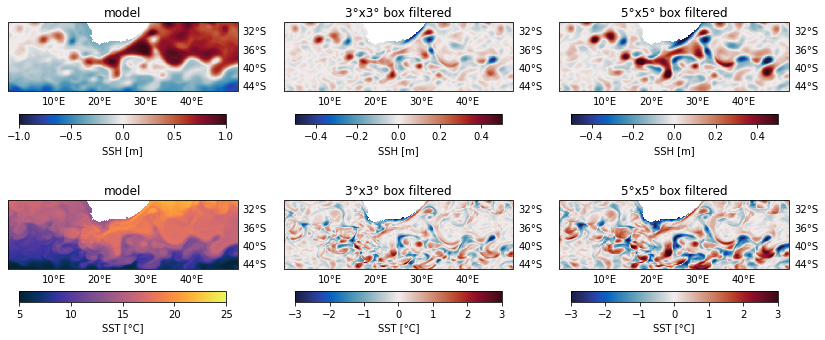

In [17]:
## plotting
data=[agulhas_ssh, (agulhas_ssh-box33_ssh),  (agulhas_ssh-box55_ssh), agulhas_sst, (agulhas_sst-box33_sst),  (agulhas_sst-box55_sst)]
title=['model', '3°x3° box filtered', '5°x5° box filtered', 'model', '3°x3° box filtered', '5°x5° box filtered']
fig = plt.figure(figsize=(14,6))
for i in range(1,4):
    var=data[i-1]
    ax = plt.subplot(2,3,i, projection=ccrs.PlateCarree())
    vmin, vmax=(-.5, .5)
    cmap=cmo.balance
    if i==1:
        vmin, vmax=(-1, 1)
        cmap=cmo.balance
    p = ax.pcolormesh(var.xt_ocean,var.yt_ocean,var,cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
    cbar = plt.colorbar(p, shrink=0.9, orientation="horizontal", label='SSH [m]') 
    ax.set_title(title[i-1])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    ax.yaxis.tick_right()
    #ax.set_xticks([-180,-120, -60, 0, 60, 120, 180], crs=ccrs.PlateCarree())
    #ax.set_yticks([-90, -60, -30, 0, 30, 60, 90], crs=ccrs.PlateCarree())
for i in range(4,7):
    var=data[i-1]
    ax = plt.subplot(2,3,i, projection=ccrs.PlateCarree())

    vmin, vmax=(-3, 3)
    cmap=cmo.balance
    if i==4:
        vmin, vmax=(5, 25)
        cmap=cmo.thermal
    p = ax.pcolormesh(var.xt_ocean,var.yt_ocean,var,cmap=cmap, vmin=vmin, vmax=vmax, transform = ccrs.PlateCarree())
    cbar = plt.colorbar(p, shrink=0.9, orientation="horizontal", label='SST [°C]') 
    ax.set_title(title[i-1])
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=1, color='black', alpha=0)
    gl.xlabels_top = False
    gl.ylabels_left = False
    ax.yaxis.tick_right()

plt.savefig('/gxfs_home/geomar/smomw577/plots/Boxcar/0181-0190/3x3vs5x5_boxcar_agulhas_ssh_sst_median.png', dpi=300)